The main challenge for me was uploading the dataset with the images. I tried doing it the way it was shown in the Assignment 6 notebook, but no luck. So I turned to my good friend ChatGPT, and found out that Google Colab doesn’t support direct folder uploads.

Eventually, I just uploaded the dataset as a ZIP file instead. I used the google.colab library to connect to my Google Drive, and added the zipfile library so I could actually open and access the content. Once I got all that set up, things went a lot smoother and I was able to keep going with the assignment.

Another hiccup was how long it took to train the model. The first run took over 10 minutes, so I decided to cut it down to 5 epochs just to save some time. I didnt to resize the images.

I decided on this modole because it seemed to be a bit more balanced. The accuracy isn’t good, but it’s pretty close. It does a solid job at catching real images, but it's  more precise when spotting the fake ones. It misses a few real images here and there, but overall it performs well.

All in all, I really enjoyed the assignment! It was challenging, but it pushed me to get creative and use other tools to figure things out.

In [ ]:
import os
import zipfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive
import random
import seaborn as sns
import pandas as pd
from tensorflow.keras import layers, models
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

drive.mount('/content/drive')
zip_path = '/content/drive/My Drive/ColabData/archive (1).zip'
extract_path = '/content/unzipped_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Image dataset shape: (1000, 128, 128, 3)
Label array shape: (1000,)


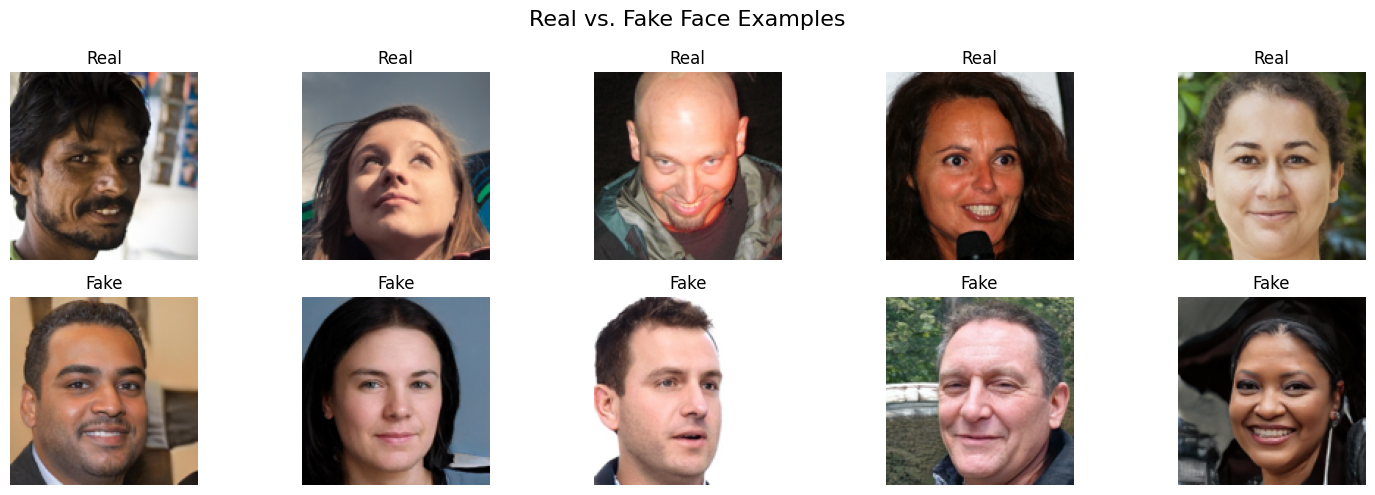

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Class names: ['fake', 'real']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,705,921 (14.14 MB)

 Trainable params: 3,705,921 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
real_path = '/content/unzipped_data/real_vs_fake/real-vs-fake/valid/real'
fake_path = '/content/unzipped_data/real_vs_fake/real-vs-fake/valid/fake'

def load_images(folder_path, label, img_size=(128, 128), limit=500):
    images = []
    labels = []


    files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
    np.random.shuffle(files)


    for i, file_name in enumerate(files):
        file_path = os.path.join(folder_path, file_name)
        img = Image.open(file_path).convert('RGB')
        img = img.resize(img_size)
        images.append(np.array(img) / 255.0)
        labels.append(label)


        if i >= limit - 1:
            break

    return images, labels


real_images, real_labels = load_images(real_path, label=0)
fake_images, fake_labels = load_images(fake_path, label=1)


X = np.array(real_images + fake_images)
y = np.array(real_labels + fake_labels)


print("Image dataset shape:", X.shape)
print("Label array shape:", y.shape)

num_examples = 5

real_indices = random.sample(range(len(real_images)), num_examples)
fake_indices = random.sample(range(len(fake_images)), num_examples)

plt.figure(figsize=(15, 5))

for i, idx in enumerate(real_indices):
    plt.subplot(2, num_examples, i + 1)  # Top row (row 1)
    plt.imshow(real_images[idx])
    plt.title("Real")
    plt.axis('off')


for i, idx in enumerate(fake_indices):
    plt.subplot(2, num_examples, num_examples + i + 1)  # Bottom row (row 2)
    plt.imshow(fake_images[idx])
    plt.title("Fake")
    plt.axis('off')

plt.suptitle("Real vs. Fake Face Examples", fontsize=16)
plt.tight_layout()
plt.show()

base_path = '/content/unzipped_data/real_vs_fake/real-vs-fake/'

img_size = (128, 128)
batch_size = 32


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path + 'train',
    labels='inferred',
    label_mode='binary',  # 0 for real, 1 for fake
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path + 'valid',
    labels='inferred',
    label_mode='binary',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path + 'test',
    labels='inferred',
    label_mode='binary',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

print("Class names:", train_ds.class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

model = models.Sequential([

    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),





    layers.MaxPooling2D(pool_size=(2, 2)),




    layers.Conv2D(64, (3, 3), activation='relu'),



    layers.MaxPooling2D(pool_size=(2, 2)),



    layers.Flatten(),



    layers.Dense(64, activation='relu'),



    layers.Dropout(0.5),



    layers.Dense(1, activation='sigmoid')])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

model.summary()

In [ ]:
epochs = 5

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2425s 776ms/step - accuracy: 0.6186 - loss: 0.6550 - val_accuracy: 0.7484 - val_loss: 0.5174
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2546s 797ms/step - accuracy: 0.7515 - loss: 0.5159 - val_accuracy: 0.8061 - val_loss: 0.4292
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2472s 774ms/step - accuracy: 0.8045 - loss: 0.4305 - val_accuracy: 0.8342 - val_loss: 0.3782
Epoch 4/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2407s 769ms/step - accuracy: 0.8353 - loss: 0.3714 - val_accuracy: 0.8555 - val_loss: 0.3506
Epoch 5/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2448s 778ms/step - accuracy: 0.8607 - loss: 0.3267 - val_accuracy: 0.8566 - val_loss: 0.3540


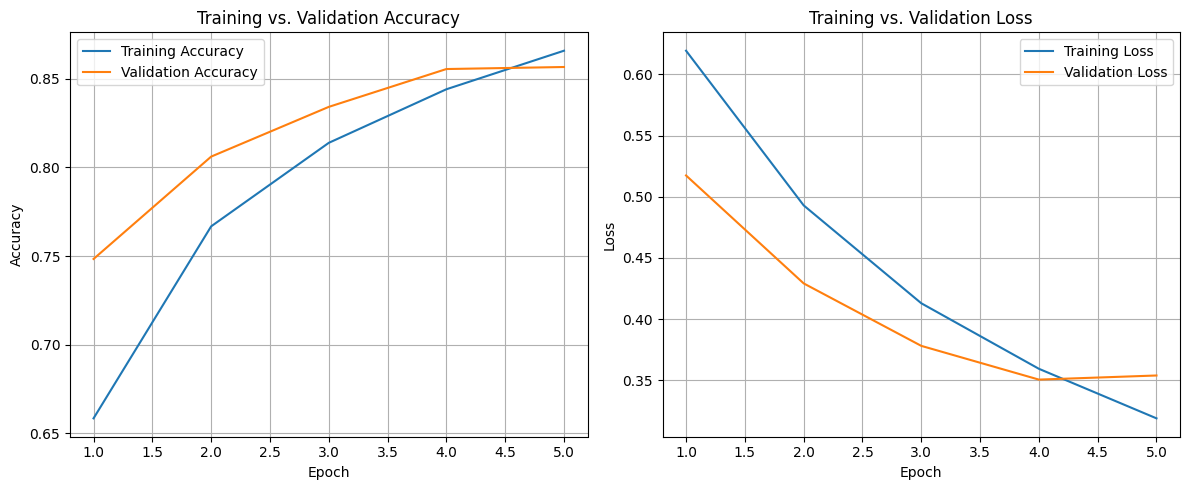

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

<Figure size 600x500 with 0 Axes>

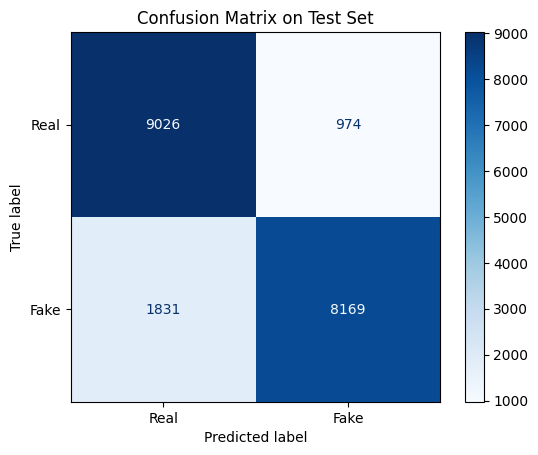

Classification Report:

              precision    recall  f1-score   support

        Real       0.83      0.90      0.87     10000
        Fake       0.89      0.82      0.85     10000

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000



In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Test Set")
plt.grid(False)
plt.show()

report = classification_report(y_true, y_pred, target_names=['Real', 'Fake'])
print("Classification Report:\n")
print(report)